# Investigation
We will be investigating what variables will have the most impact on a house's market price.  We will be investigating from the perspective of a start up company which buys inexpensive houses and "flips" them for profit.

## Objectives:

* Find what aspects of a house have a significant impact on house's value
* Discover how much a house's value will change based on a changes in condition
* Find the areas that are more profitable to sell homes. 

# Obtaining data
Time to import the necessary libraries and initialize a data frame containing the data from the CSV file.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import stats
import statsmodels.stats.api as sms

sns.set_style('darkgrid')

## Initializing data frame

In [2]:
df = pd.read_csv('csv_files/kc_house_data.csv')
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB
None


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


# Scrubbing the Data
Now that the data frame has been initialized, we'll start cleaning.

Notes: Problems that I can immediately see are: 
* waterfront, view, and yr_renovated are missing values. 
* sqft_basement and dates are objects instead of integer/float and datetime, respectively. 

## Waterfront

In [3]:
print(df.waterfront.value_counts())
waterfront = df[df['waterfront'] == 1.0]
waterfront['price'].describe()


0.0    19075
1.0      146
Name: waterfront, dtype: int64


count    1.460000e+02
mean     1.717215e+06
std      1.145385e+06
min      2.850000e+05
25%      8.275000e+05
50%      1.510000e+06
75%      2.282500e+06
max      7.060000e+06
Name: price, dtype: float64

In [4]:
# Looked at low end prices of waterfront properties out of curiousity.
# waterfront will play a significant role in price.  Replacing NaN's with 
# median
df.waterfront.fillna(df['waterfront'].median(), inplace=True)
df.waterfront.isna().sum()

0

## Yr_renovated

In [5]:
# Checking out yr_renovated  ***Take deeper look into this***
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [6]:
# Since having data about renovated homes might be useful, filling NaN's with
# median
df.yr_renovated.fillna(df['yr_renovated'].median())

0           0.0
1        1991.0
2           0.0
3           0.0
4           0.0
          ...  
21592       0.0
21593       0.0
21594       0.0
21595       0.0
21596       0.0
Name: yr_renovated, Length: 21597, dtype: float64

### Is It Categorical? 

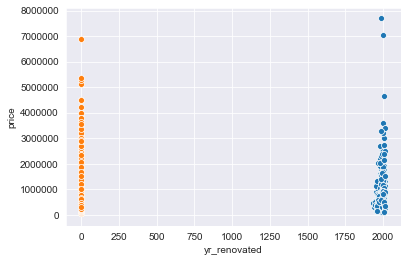

In [7]:
# checking the impact of homes renovated versus not renovated against price

no_reno = df[df['yr_renovated'] == 0]

reno = df[df['yr_renovated'] != 0]

sns.scatterplot(x=reno['yr_renovated'], y=reno['price'])
sns.scatterplot(x=no_reno['yr_renovated'], y=no_reno['price'])

The columns 'yr_renovated' is categorical so we'll alter data frame to represent this.  Renovated homes will be represented by a 1 and non-renovated homes will be represented by a 0. 

In [8]:
for i in range(len(df['yr_renovated'])):
    if df['yr_renovated'].iloc[i] != 0.0:
        df['yr_renovated'].iloc[i] = 1.0
# change name to just renovated
df = df.rename(columns={'yr_renovated' : 'renovated'})

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,1.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Judging from this graph, and knowing that the number of non-renovated homes far exceeds the number of renovated homes, I see that whether a home has been renovated or not has 

## View

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64
id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view             63
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
renovated         0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
dtype: int64


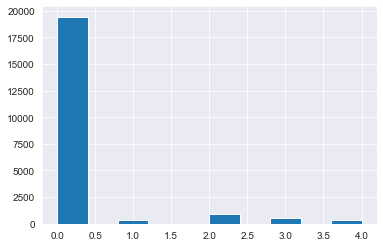

In [10]:
# view column refers to how many times the home has been viewed
print(df.view.value_counts())
print(df.isnull().sum())
df.view.hist()

In [11]:
med_vu = df.view.median()
med_vu

0.0

In [12]:
# Only makes up 0.29% of total data, but the median does not change the 
# create a new category.  Fill with median.
df.fillna(value=med_vu, inplace=True)
df.view.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: view, dtype: float64

## Date

In [13]:
# Time to deal with object types.
import datetime as dt
df.date.head()

0    10/13/2014
1     12/9/2014
2     2/25/2015
3     12/9/2014
4     2/18/2015
Name: date, dtype: object

In [14]:
# convert 'date' to datetime, then creating 2 new columns so that we can work
# with numerical data
df.date = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear


## Sqft_Basement

In [15]:
# inspecting sqft_basement values
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1245.0        1
2350.0        1
1990.0        1
2360.0        1
1913.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [16]:
# 452 values of '?'. Makes up 2.1% of our data. 
med_bsmt = df[df['sqft_basement'] != '?']
med = med_bsmt.sqft_basement.median()

for i in range(len(df['sqft_basement'])):
    if df['sqft_basement'].iloc[i] == '?':
        df['sqft_basement'].iloc[i] = str(med)


df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
1525.0        1
1245.0        1
2350.0        1
1990.0        1
1913.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [17]:
# convert to float
df['sqft_basement'] = df.sqft_basement.astype(float)
df.sqft_basement.dtype

dtype('float64')

### Change to Categorical Format

In [18]:
for i in range(len(df['sqft_basement'])):
    if df['sqft_basement'].iloc[i] != 0.0:
        df['sqft_basement'].iloc[i] = 1.0
        
df = df.rename(columns={'sqft_basement' : 'basement'})
df.basement.head()

0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: basement, dtype: float64

## Checking for duplicates

In [19]:
# checking for duplicates
dups = df[df.duplicated(['id'],keep=False)]
dups.groupby('id', axis=1)
dups


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day_of_year
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,1.0,1939,0.0,98117,47.6870,-122.386,1570,4500,7,206
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,1.0,1939,0.0,98117,47.6870,-122.386,1570,4500,12,357
313,4139480200,2014-06-18,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,1.0,1997,0.0,98006,47.5503,-122.102,3860,11244,6,169
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,1.0,1997,0.0,98006,47.5503,-122.102,3860,11244,12,343
324,7520000520,2014-09-05,232000.0,2,1.00,1240,12092,1.0,0.0,0.0,...,1.0,1922,1.0,98146,47.4957,-122.352,1820,7460,9,248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20654,8564860270,2015-03-30,502000.0,4,2.50,2680,5539,2.0,0.0,0.0,...,0.0,2013,0.0,98045,47.4759,-121.734,2680,5992,3,89
20763,6300000226,2014-06-26,240000.0,4,1.00,1200,2171,1.5,0.0,0.0,...,0.0,1933,0.0,98133,47.7076,-122.342,1130,1598,6,177
20764,6300000226,2015-05-04,380000.0,4,1.00,1200,2171,1.5,0.0,0.0,...,0.0,1933,0.0,98133,47.7076,-122.342,1130,1598,5,124
21564,7853420110,2014-10-03,594866.0,3,3.00,2780,6000,2.0,0.0,0.0,...,0.0,2013,0.0,98065,47.5184,-121.886,2850,6000,10,276


In [20]:
# duplicates indicate that the houses were sold more than once. Creating 
# subset  of data to see if duplicates were purchased by house flippers
flips = dups[['id', 'date', 'price', 'condition', 'grade']]
flips.head(20)

,id,date,price,condition,grade
93,6021501535,2014-07-25,430000.0,3,8
94,6021501535,2014-12-23,700000.0,3,8
313,4139480200,2014-06-18,1380000.0,3,11
314,4139480200,2014-12-09,1400000.0,3,11
324,7520000520,2014-09-05,232000.0,3,6
325,7520000520,2015-03-11,240500.0,3,6
345,3969300030,2014-07-23,165000.0,3,6
346,3969300030,2014-12-29,239900.0,3,6
371,2231500030,2014-10-01,315000.0,5,7
372,2231500030,2015-03-24,530000.0,5,7


Houses were bought at lower price and sold later at a higher price, but
**grade and condition stayed the same**. Grade and condition of these homes **did not** play a significant role in the sales of these homes. **Homes may not have been flipped**.

In [21]:
# To prevent noise in our data, will remove duplicates and keeping the most
# most recent sale price

df = df.drop_duplicates(subset='id', keep='last')
df.duplicated(['id']).value_counts()

False    21420
dtype: int64

In [22]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day_of_year
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,286
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1.0,1951,1.0,98125,47.7210,-122.319,1690,7639,12,343
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,1933,1.0,98028,47.7379,-122.233,2720,8062,2,56
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,343
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,49


In [23]:
# Cleaning done. Creating new CSV file.
df.reset_index()
df.to_csv('csv_files/kc_house_data_clean.csv')

# Exploring the Data
We've done some investigation of the data already, but that was used more as a 
means to clean the data. Now we'll investigate relationships and check for 
correlations and multicollinearity.

In [24]:
rdf = pd.read_csv('csv_files/kc_house_data_clean.csv')
rdf = rdf.drop(columns='Unnamed: 0', axis=1)
rdf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day_of_year
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,286
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1.0,1951,1.0,98125,47.7210,-122.319,1690,7639,12,343
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,1933,1.0,98028,47.7379,-122.233,2720,8062,2,56
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,343
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,49


<Figure size 576x360 with 0 Axes>

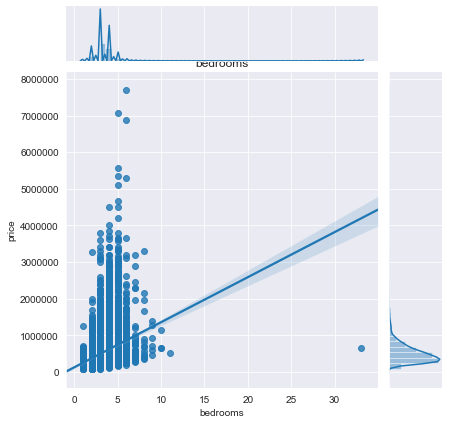

<Figure size 576x360 with 0 Axes>

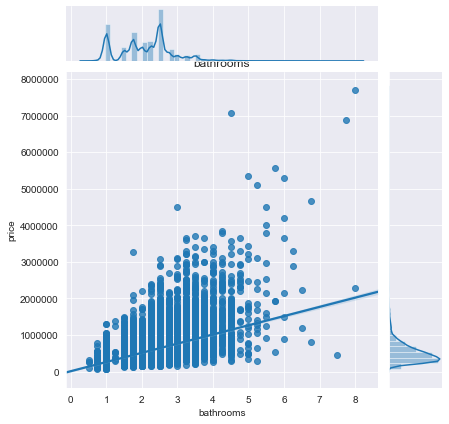

<Figure size 576x360 with 0 Axes>

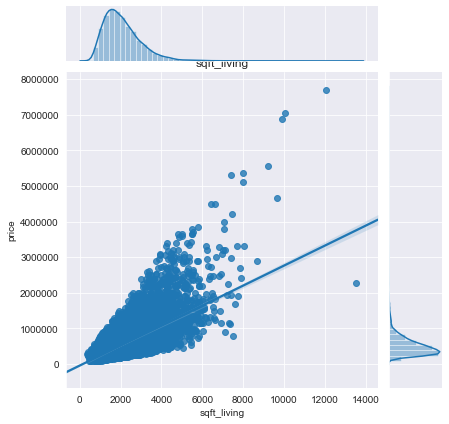

<Figure size 576x360 with 0 Axes>

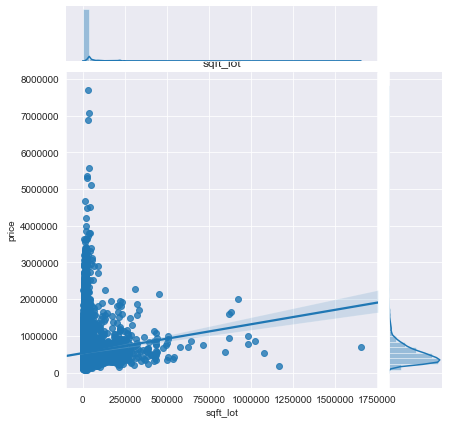

<Figure size 576x360 with 0 Axes>

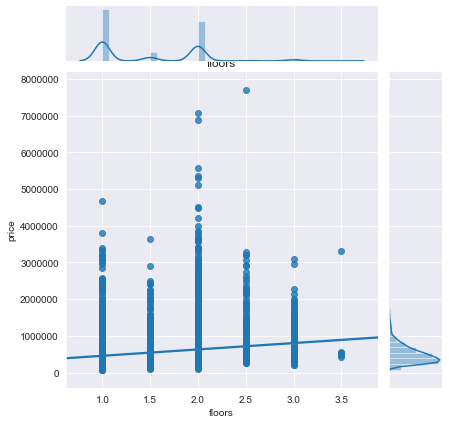

<Figure size 576x360 with 0 Axes>

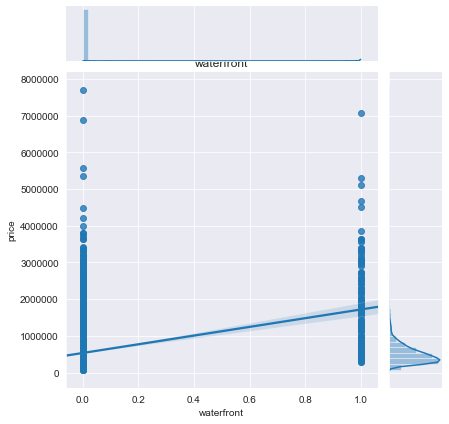

<Figure size 576x360 with 0 Axes>

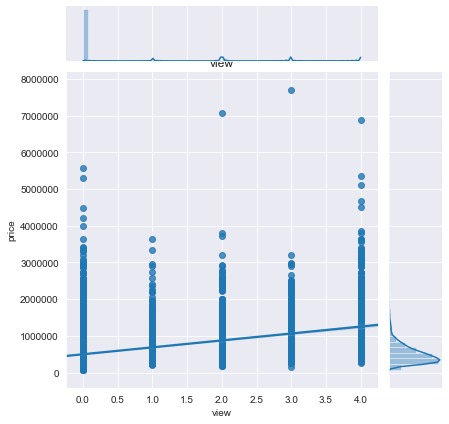

<Figure size 576x360 with 0 Axes>

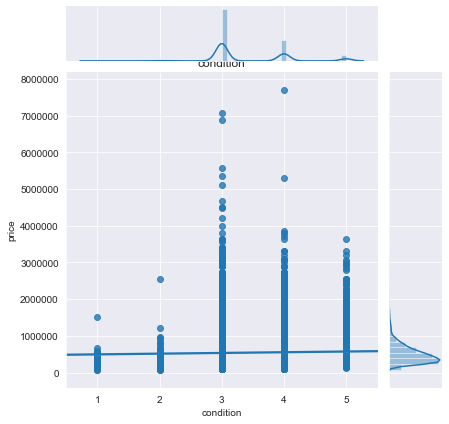

<Figure size 576x360 with 0 Axes>

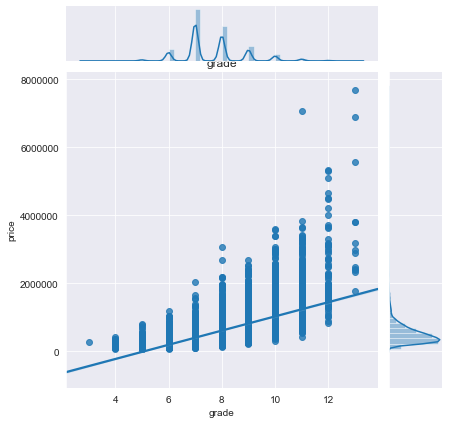

<Figure size 576x360 with 0 Axes>

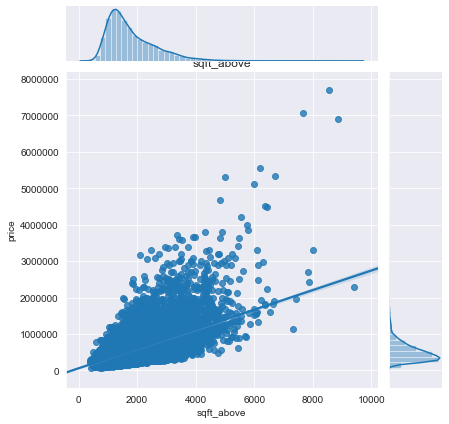

<Figure size 576x360 with 0 Axes>

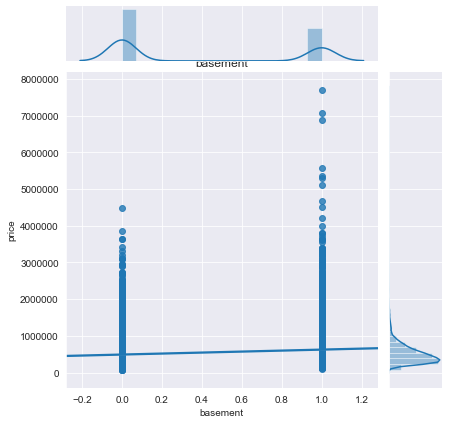

<Figure size 576x360 with 0 Axes>

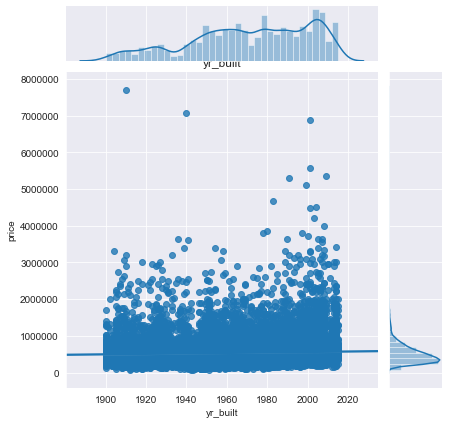

<Figure size 576x360 with 0 Axes>

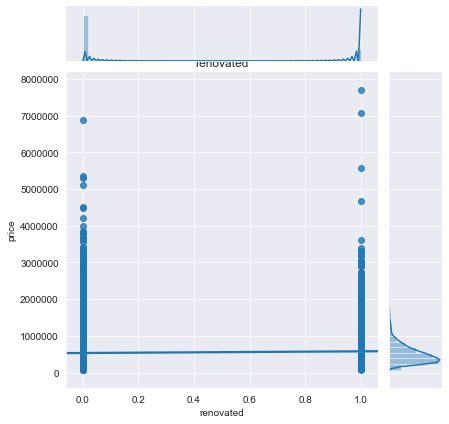

<Figure size 576x360 with 0 Axes>

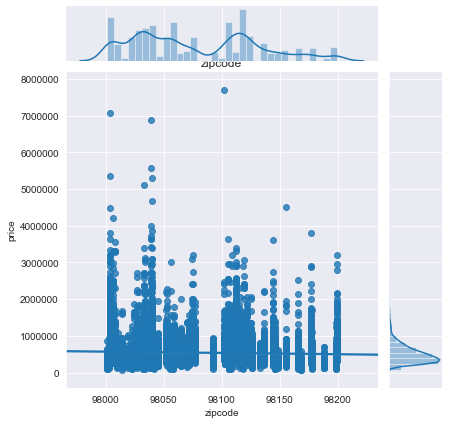

<Figure size 576x360 with 0 Axes>

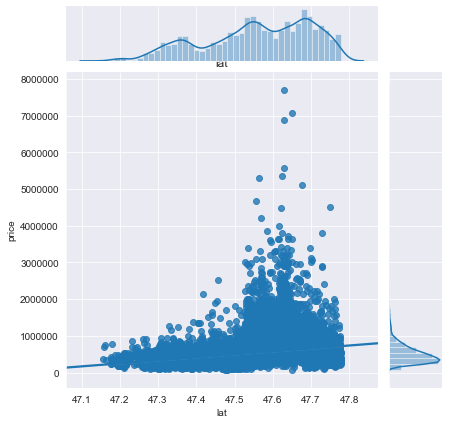

<Figure size 576x360 with 0 Axes>

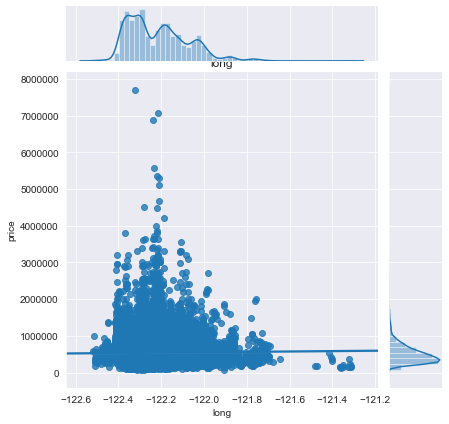

<Figure size 576x360 with 0 Axes>

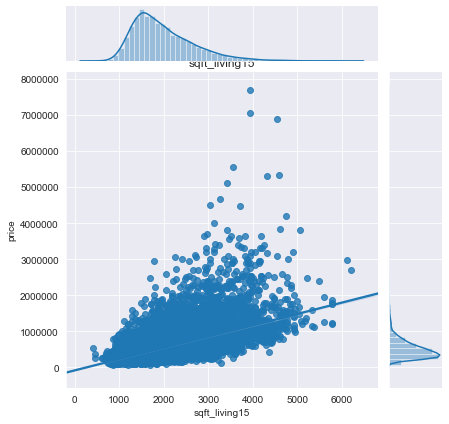

<Figure size 576x360 with 0 Axes>

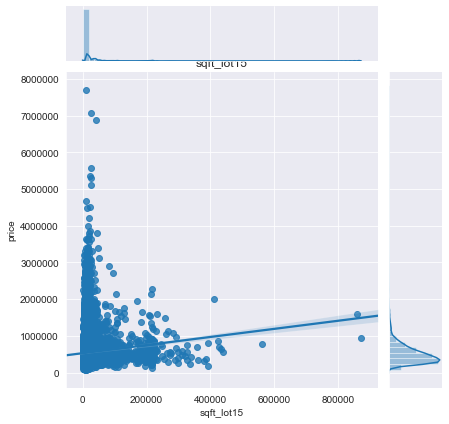

<Figure size 576x360 with 0 Axes>

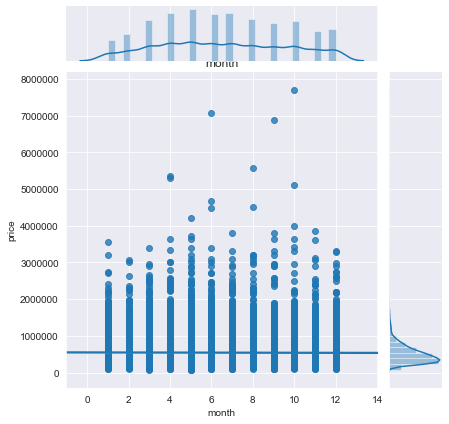

<Figure size 576x360 with 0 Axes>

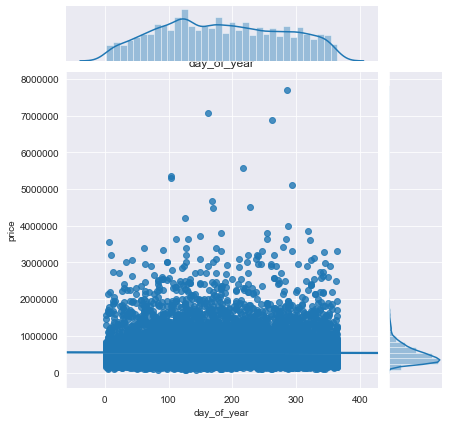

In [25]:
no_date = rdf.drop(['date', 'id', 'price'], axis=1)

for col in no_date.columns:
    plt.figure(figsize=(8,5))
    sns.jointplot(x= col, y= 'price', data=rdf, kind='reg')
    plt.title(col)

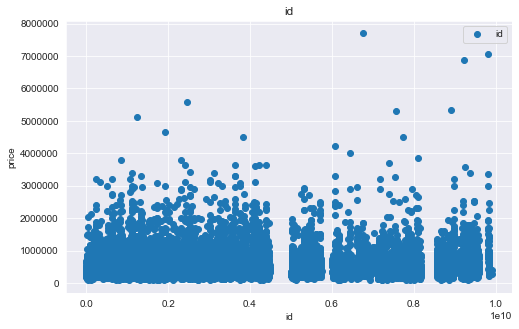

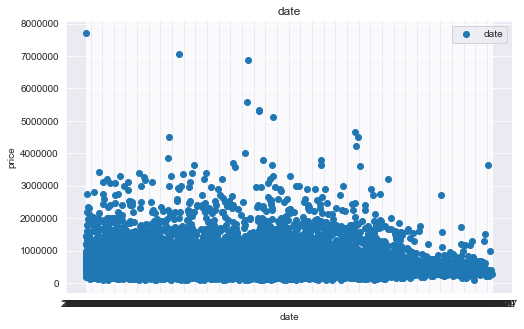

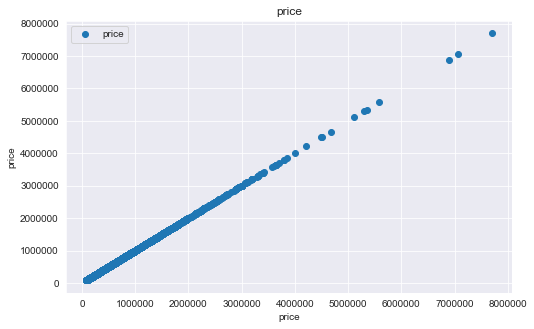

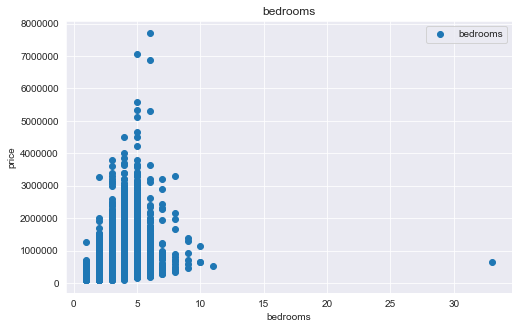

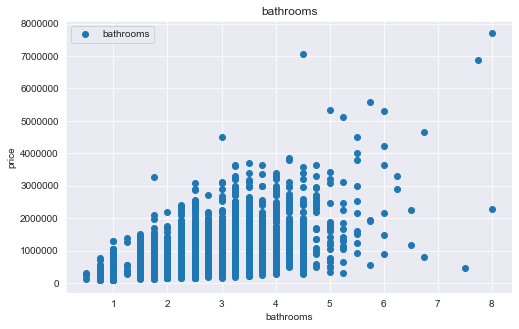

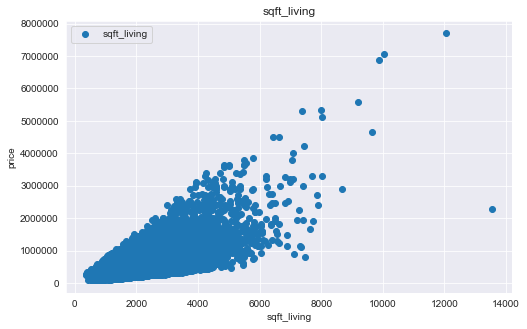

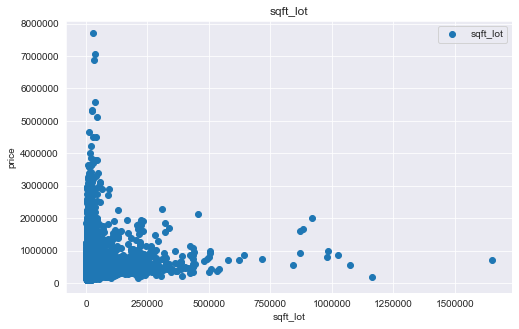

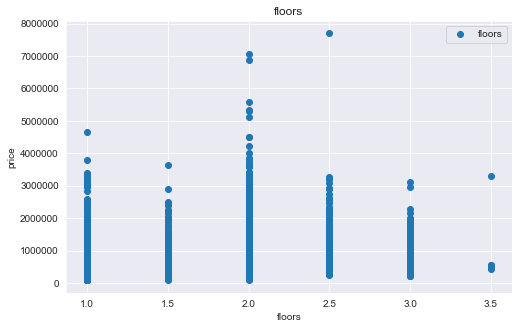

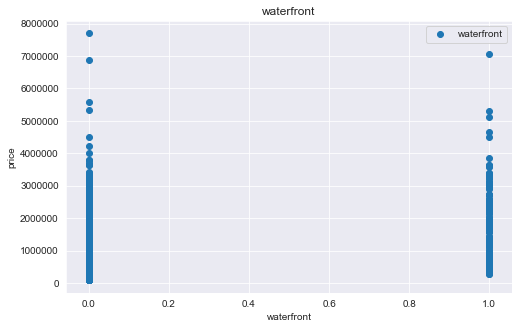

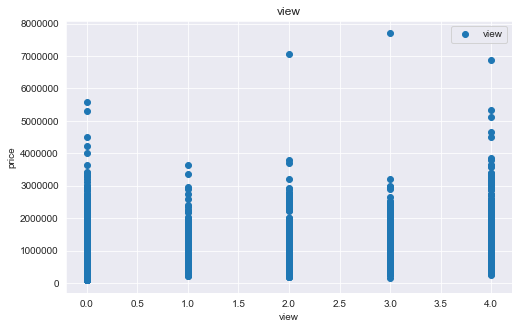

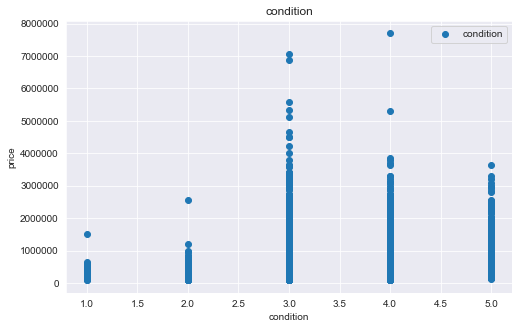

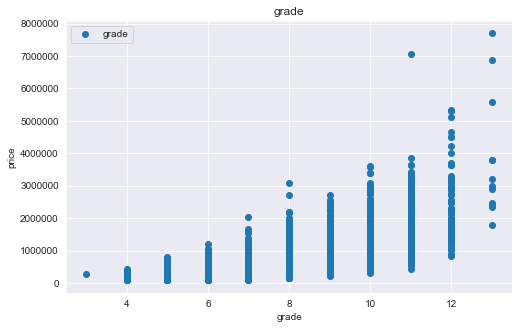

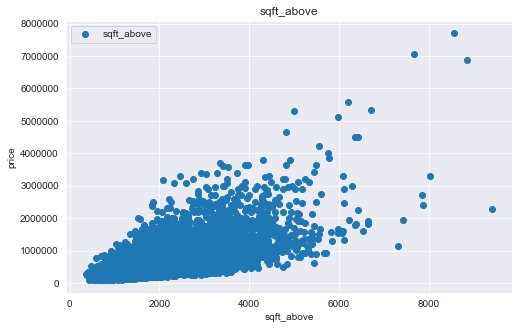

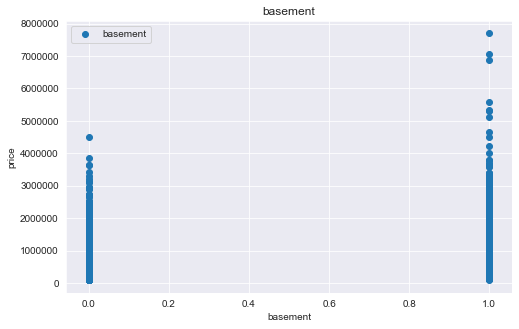

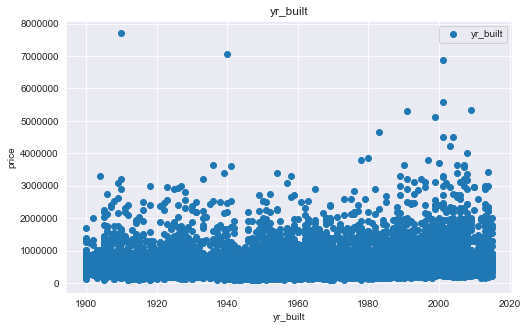

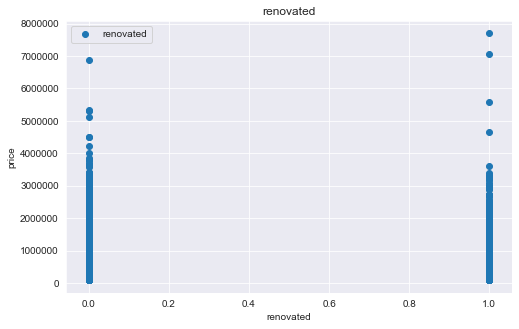

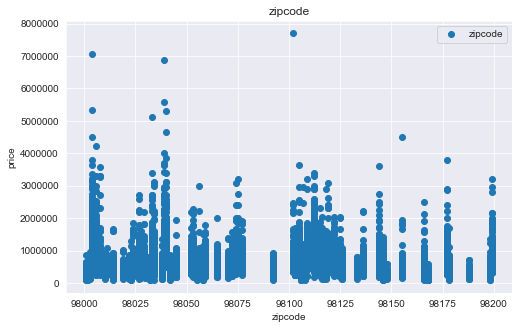

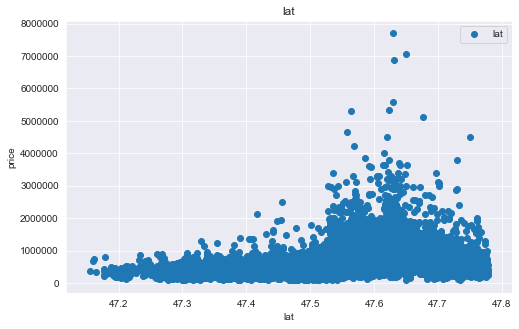

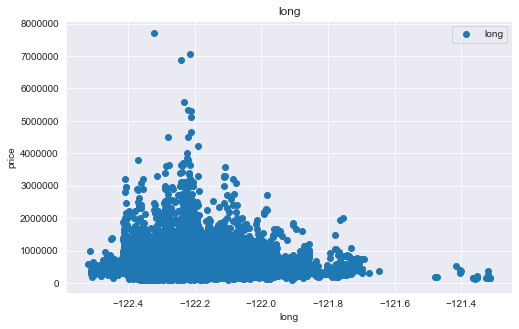

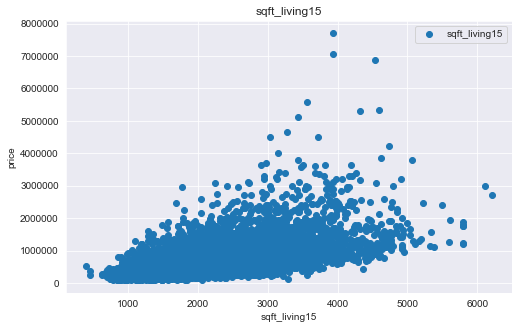

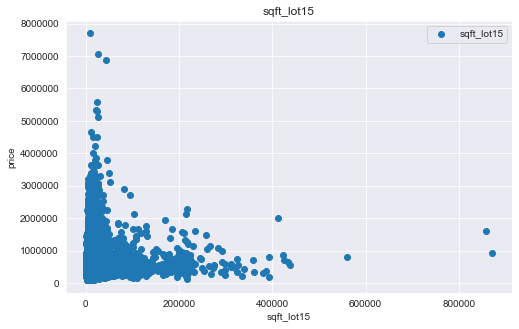

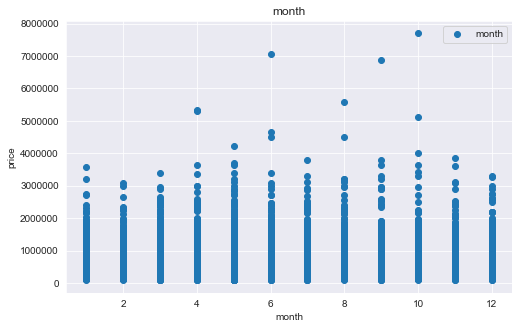

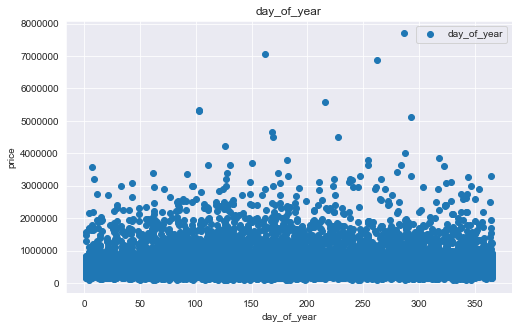

In [26]:
# using for loop to visualize relationship of the different columns to 'price'

for col in rdf.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(rdf[col], rdf['price'], label=col)
    plt.xlabel(col)
    plt.ylabel('price')
    plt.title(col)
    plt.legend()
    plt.show()


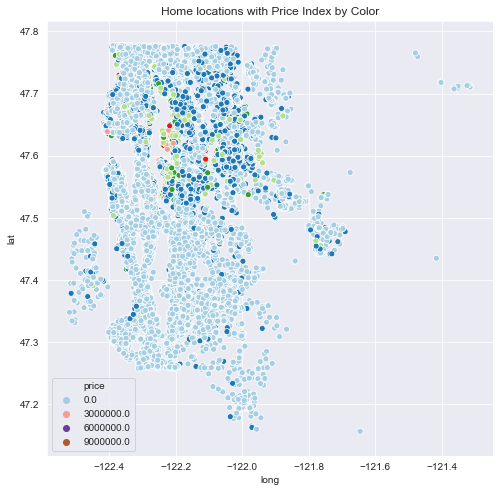

In [27]:
long = rdf['long']
lat = rdf['lat']
plt.figure(figsize=(8,8))
sns.scatterplot(x=long, y=lat, hue='price', data=rdf, palette='Paired')
plt.title('Home locations with Price Index by Color')
plt.legend(fancybox=True)

In [28]:
print(long.describe())
print(lat.describe())

count    21420.000000
mean      -122.213784
std          0.140791
min       -122.519000
25%       -122.328000
50%       -122.230000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64
count    21420.000000
mean        47.560197
std          0.138589
min         47.155900
25%         47.471200
50%         47.572100
75%         47.678100
max         47.777600
Name: lat, dtype: float64


### Initial Observations: 
   * Grade has a linear rather linear relationship to price. May break these up into bins to consolidate dummy variables 
   * Square foot above ground seems to also have a somewhat linear relationship
   * Distributions of longitude and latitude seem to point at areas that have higher land value. 
   * Lot size of the home or nearest neighbors seems to have little effect on price
   * Need to deal with sizes of categorical data.

## Baseline Model

In [29]:
target = 'price'

feats = rdf.drop(['price', 'date', 'id'], axis=1).columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=rdf).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
==================================================================================
Model:                    OLS                  Adj. R-squared:         0.700      
Dependent Variable:       price                AIC:                    584013.2493
Date:                     2020-07-15 16:31     BIC:                    584180.6630
No. Observations:         21420                Log-Likelihood:         -2.9199e+05
Df Model:                 20                   F-statistic:            2497.      
Df Residuals:             21399                Prob (F-statistic):     0.00       
R-squared:                0.700                Scale:                  4.0558e+10 
----------------------------------------------------------------------------------
                 Coef.       Std.Err.      t     P>|t|     [0.025        0.975]   
----------------------------------------------------------------------------------
Intercept     7325538.2579 2956527.0837   2.4778 0.0132 1530523.8788 13120552.6371
bedrooms       -36399.8754    1912.6774 -19.0308 0.0000  -40148.8664   -32650.8844
bathrooms       44324.2950    3281.9993  13.5053 0.0000   37891.3306    50757.2593
sqft_living       152.7264       6.0299  25.3280 0.0000     140.9072      164.5455
sqft_lot            0.1235       0.0480   2.5743 0.0101       0.0295        0.2176
floors           7807.2798    3610.4614   2.1624 0.0306     730.5052    14884.0543
waterfront     623687.3898   18146.2247  34.3701 0.0000  588119.4312   659255.3485
view            53199.2275    2132.4615  24.9473 0.0000   49019.4433    57379.0116
condition       25075.0084    2343.2520  10.7009 0.0000   20482.0591    29667.9577
grade           97325.4834    2175.9124  44.7286 0.0000   93060.5321   101590.4346
sqft_above         27.9182       6.6038   4.2276 0.0000      14.9743       40.8622
basement        -2976.6959    5092.8630  -0.5845 0.5589  -12959.0885     7005.6967
yr_built        -2754.4449      69.7754 -39.4759 0.0000   -2891.2100    -2617.6799
renovated        8340.9760    3401.6520   2.4520 0.0142    1673.4836    15008.4685
zipcode          -588.6123      33.2121 -17.7228 0.0000    -653.7105     -523.5141
lat            600365.9014   10784.6359  55.6686 0.0000  579227.2078   621504.5950
long          -217629.4436   13246.8069 -16.4288 0.0000 -243594.1766  -191664.7105
sqft_living15      20.3409       3.4614   5.8765 0.0000      13.5563       27.1255
sqft_lot15         -0.3826       0.0735  -5.2084 0.0000      -0.5266       -0.2386
month           12377.5809    4847.9414   2.5532 0.0107    2875.2528    21879.9090
day_of_year      -508.8855     159.3874  -3.1928 0.0014    -821.2968     -196.4743
----------------------------------------------------------------------------------
Omnibus:                 18251.961          Durbin-Watson:             1.996      
Prob(Omnibus):           0.000              Jarque-Bera (JB):          1848616.196
Skew:                    3.578              Prob(JB):                  0.000      
Kurtosis:                47.945             Condition No.:             216266025  
==================================================================================
* The condition number is large (2e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

 Kurtosis is extremely high.  Have not made dummies or finished binning the
 categorical data, but this is a good start.

### Formating Additional Categorical Data
It's time to address the categorical data that we haven't yet formatted
into friendlier sizes so that our model 

#### Zip Codes

In [30]:
zips = len(rdf['zipcode'].unique())
zips

70

In [31]:
# 70 different zipcodes. Need to group these preferably into 6 sectors
# sec_1 long = long.min()<= x < -122.3, lat = lat.max()<= y > 47.5 
# sec_2 long = -122.3 <= x < -122.0 , lat = lat.max()<= y > 47.5
# sec_3 long = -122.0 <= x =< long.max() , lat = lat.max()<= y > 47.5
# sec_4 long = long.min()<= x < -122.3, lat = lat.min()<= y <= 47.5 
# sec_5 long = long = -122.3 <= x < -122.0 , lat = lat.min()<= y <= 47.5
# sec_6 long = long = -122.0 <= x =< long.max() , lat = lat.min()<= y <= 47.5
rdf['sec_1'] = rdf[[]]

ValueError: Wrong number of items passed 0, placement implies 1

#### Grade

In [32]:
rdf['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13], dtype=int64)

Unique values are 3-13.  If we bin by every 3 numbers, we'll lose value 13 Creating bins are based on odd numbers, we'll be able to account for all of
the values

Text(0, 0.5, 'value counts')

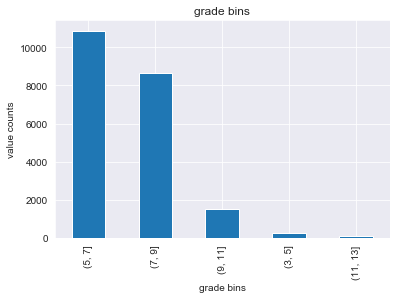

In [33]:
bins = [3, 5, 7, 9, 11, 13]
bin_grd = pd.cut(df['grade'], bins)
bin_grd = bin_grd.cat.as_ordered()

bin_grd.value_counts().plot(kind='bar')
plt.title('grade bins')
plt.xlabel('grade bins')
plt.ylabel('value counts')

In [35]:
# now to afix this to our data frame and create dummies
rdf['grade'] = bin_grd
rdf['grade'] = rdf['grade'].cat.codes
# Creating dummies
gbin_dummies = pd.get_dummies(bin_grd, prefix='grade') #keeping first column 
                                                # so future names make sense

adf = rdf.drop(['id', 'grade'], axis=1)
adf = pd.concat([rdf, gbin_dummies], axis=1)
adf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,month,day_of_year,"grade_(3, 5]","grade_(5, 7]","grade_(7, 9]","grade_(9, 11]","grade_(11, 13]"
0,7.129301e+09,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,...,-122.257,1340.0,5650.0,10.0,286.0,0.0,1.0,0.0,0.0,0.0
1,6.414100e+09,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,...,-122.319,1690.0,7639.0,12.0,343.0,0.0,1.0,0.0,0.0,0.0
2,5.631500e+09,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,...,-122.233,2720.0,8062.0,2.0,56.0,0.0,1.0,0.0,0.0,0.0
3,2.487201e+09,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,...,-122.393,1360.0,5000.0,12.0,343.0,0.0,1.0,0.0,0.0,0.0
4,1.954401e+09,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,...,-122.045,1800.0,7503.0,2.0,49.0,0.0,0.0,1.0,0.0,0.0


Those names are annoying, so we'll rename and simplify them for easier reference

In [53]:
adf1 = adf.rename(columns={'grade_(3, 5]':'1star', 'grade_(5, 7]':'2star', 
                           'grade_(7, 9]':'3star', 'grade_(9, 11]':'4star', 
                           'grade_(11, 13]':'5star'})
adf1.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,month,day_of_year,1star,2star,3star,4star,5star
21592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0
21593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0
21594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
21595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0
21596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0


In [54]:
# Creating dummies reintroduced NaN values. Dropping NaNs.
adf2 = adf1.dropna(how='any')
adf2.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
basement         0
yr_built         0
renovated        0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month            0
day_of_year      0
1star            0
2star            0
3star            0
4star            0
5star            0
dtype: int64

In [55]:
adf2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,month,day_of_year,1star,2star,3star,4star,5star
0,7.129301e+09,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,...,-122.257,1340.0,5650.0,10.0,286.0,0.0,1.0,0.0,0.0,0.0
1,6.414100e+09,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,...,-122.319,1690.0,7639.0,12.0,343.0,0.0,1.0,0.0,0.0,0.0
2,5.631500e+09,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,...,-122.233,2720.0,8062.0,2.0,56.0,0.0,1.0,0.0,0.0,0.0
3,2.487201e+09,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,...,-122.393,1360.0,5000.0,12.0,343.0,0.0,1.0,0.0,0.0,0.0
4,1.954401e+09,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,...,-122.045,1800.0,7503.0,2.0,49.0,0.0,0.0,1.0,0.0,0.0


Try new model

In [57]:
target = 'price'

feats = adf2.drop(['price', 'date', 'id','1star'], axis=1).columns

preds = '+'.join(feats)

formula1 = target + '~' + preds
model1 = smf.ols(formula=formula1, data=adf2).fit()
model1.summary2()

SyntaxError: invalid syntax (<unknown>, line 1)